Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")


Load Dataset

In [3]:
df_lagged = pd.read_csv(r"C:\Users\dylan\OneDrive - HvA\AAI Master\BLOK 3 afstuderen\Thesis\Eigenwerk\DATASET\df_lagged.csv")  # Pad aanpassen indien nodig
target_col = 'Totaal_verkochte_wegvoertuigen'
drop_cols = ['Periode', target_col]


Define Feature Sets

In [12]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

# Load dataset
df_lagged = pd.read_csv(r"C:\Users\dylan\OneDrive - HvA\AAI Master\BLOK 3 afstuderen\Thesis\Eigenwerk\DATASET\df_lagged.csv")

# Define drop columns and target
target_col = 'Totaal_verkochte_wegvoertuigen'
drop_cols = ['Periode', target_col]

# Define lag and time features
lag_time_features = ['TVV_Lag1', 'TVV_Lag2', 'TVV_Lag3', 'TVV_Lag4', 'TVV_Lag5', 'TVV_Lag6', 'year', 'month', 'quarter']

# Define feature sets
feature_sets = {
    '(Lag Only)': lag_time_features,
    'Keywords + Lag': lag_time_features + ['thuis opladen', 'elektrische auto', 'hybride elektrisch'],
    'Bijtelling + Lag': lag_time_features + ['Bijtelling (%)'],
    'Confidence + Lag': lag_time_features + ['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'Grote aankopen'],
    'Fuel + Lag': lag_time_features + [
        'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
        'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
        'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
    ]
}

# Define all features excluding drop columns
all_features = [col for col in df_lagged.columns if col not in drop_cols]
feature_sets['All Features'] = all_features

# Define models (ARIMA/ARIMAX handled separately)
models = {
    'Linear Regression': lambda: LinearRegression(),
    'XGBoost': lambda: XGBRegressor(n_estimators=100, verbosity=0, random_state=42),
    'ARIMA (Lag Only)': lambda: None,
    'ARIMAX': lambda: None
}

# Display feature sets and model names to confirm setup
feature_sets.keys(), models.keys()


(dict_keys(['(Lag Only)', 'Keywords + Lag', 'Bijtelling + Lag', 'Confidence + Lag', 'Fuel + Lag', 'All Features']),
 dict_keys(['Linear Regression', 'XGBoost', 'ARIMA (Lag Only)', 'ARIMAX']))

Define Walk-Forward Function

In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def walk_forward_validation_with_valset(
    df, features, target_col, model_fn,
    forecast_horizon=3, initial_train_size=12, step_size=3, val_split_ratio=0.1
):
    X = df[features].values
    y = df[target_col].values
    predictions, actuals = [], []

    for i in range(initial_train_size, len(df) - forecast_horizon + 1, step_size):
        # Expanding train window
        X_train_full, y_train_full = X[:i], y[:i]

        # Split into train and validation
        val_size = int(len(X_train_full) * val_split_ratio)
        train_end = len(X_train_full) - val_size

        X_train, X_val = X_train_full[:train_end], X_train_full[train_end:]
        y_train, y_val = y_train_full[:train_end], y_train_full[train_end:]

        # Test set
        X_test = X[i:i + forecast_horizon]
        y_test = y[i:i + forecast_horizon]

        # Initialize model
        model = model_fn()

        # Check if model supports early stopping (e.g., XGBoost)
        if hasattr(model, "fit") and "eval_set" in model.fit.__code__.co_varnames:
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                early_stopping_rounds=10,
                verbose=False
            )
        else:
            model.fit(X_train_full, y_train_full)  # fallback: no valset used

        y_pred = model.predict(X_test)
        predictions.extend(y_pred)
        actuals.extend(y_test)

    # Evaluation over all predictions
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)
    mape = np.mean(np.abs((np.array(actuals) - np.array(predictions)) / np.array(actuals))) * 100

    return mae, rmse, r2, mape, predictions, actuals


Run Models on All Feature Sets

 Visualiseer Resultaten

Baseline training: 'Lag Only' features

In [37]:
# Gebruik de aangepaste functie met interne validatie
def model_fn_xgb():
    return XGBRegressor(n_estimators=1000, random_state=42, verbosity=0)

def model_fn_lr():
    return LinearRegression()

# Pas deze functie toe om validatiescores op te halen in plaats van testset
mae_lr, rmse_lr, r2_lr, mape_lr, _, _ = walk_forward_validation_with_valset(
    df_lagged, lag_features, target_col, model_fn_lr,
    forecast_horizon=3, initial_train_size=12, step_size=3, val_split_ratio=0.1
)

mae_xgb, rmse_xgb, r2_xgb, mape_xgb, _, _ = walk_forward_validation_with_valset(
    df_lagged, lag_features, target_col, model_fn_xgb,
    forecast_horizon=3, initial_train_size=12, step_size=3, val_split_ratio=0.1
)

# Voor ARIMA blijft dit via testset, tenzij je aparte tuning toevoegt
arima_result = walkforward_arima(df_lagged, lag_features, target_col)

# Resultaten printen
print("Linear Regression (Lag Only, valset):", mae_lr, rmse_lr, r2_lr, mape_lr)
print("XGBoost (Lag Only, valset):", mae_xgb, rmse_xgb, r2_xgb, mape_xgb)
print("ARIMA (Lag Only, testset):", arima_result["MAE"], arima_result["RMSE"], arima_result["R²"], arima_result["MAPE"])


Linear Regression (Lag Only, valset): 1768.2421890008452 4560.187794187986 0.7496763854834743 31.11960127590205
XGBoost (Lag Only, valset): 1325.426858304727 2987.8305707919394 0.8925396381595114 22.50975276552194
ARIMA (Lag Only, testset): 3626.0302859075537 6166.998639239298 0.5777994960215638 37.731145993625574


All featurus:

In [ ]:
# Gebruik de aangepaste functie met interne validatie
def model_fn_xgb():
    return XGBRegressor(n_estimators=1000, random_state=42, verbosity=0)

def model_fn_lr():
    return LinearRegression()

# Pas deze functie toe om validatiescores op te halen in plaats van testset
mae_lr, rmse_lr, r2_lr, mape_lr, _, _ = walk_forward_validation_with_valset(
    df_lagged, lag_features, target_col, model_fn_lr,
    forecast_horizon=3, initial_train_size=12, step_size=3, val_split_ratio=0.1
)

mae_xgb, rmse_xgb, r2_xgb, mape_xgb, _, _ = walk_forward_validation_with_valset(
    df_lagged, lag_features, target_col, model_fn_xgb,
    forecast_horizon=3, initial_train_size=12, step_size=3, val_split_ratio=0.1
)

# Voor ARIMA blijft dit via testset, tenzij je aparte tuning toevoegt
arima_result = walkforward_arima(df_lagged, lag_features, target_col)

# Resultaten printen
print("Linear Regression (Lag Only, valset):", mae_lr, rmse_lr, r2_lr, mape_lr)
print("XGBoost (Lag Only, valset):", mae_xgb, rmse_xgb, r2_xgb, mape_xgb)
print("ARIMA (Lag Only, testset):", arima_result["MAE"], arima_result["RMSE"], arima_result["R²"], arima_result["MAPE"])


Linear Regression (Lag Only): 1768.2421890008452 4560.187794187986 0.7496763854834743 31.11960127590205
XGBoost (Lag Only): 1325.425039426245 2987.822921395333 0.8925401883954471 22.50973567065283
ARIMA (Lag Only): 3626.0302859075537 6166.998639239298 0.5777994960215638 37.731145993625574


In [32]:
# Helper function to print metrics for each window and the average
def print_window_metrics(mae_list, rmse_list, r2_list, mape_list, model_name):
    print(f"\n{model_name} (Lag Only) - Per Window:")
    for i, (mae, rmse, r2, mape) in enumerate(zip(mae_list, rmse_list, r2_list, mape_list)):
        print(f"  Window {i+1}: MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.3f}, MAPE={mape:.2f}%")
    print(f"Average: MAE={np.mean(mae_list):.2f}, RMSE={np.mean(rmse_list):.2f}, R²={np.mean(r2_list):.3f}, MAPE={np.mean(mape_list):.2f}%")

# Modified walk_forward_validation to return per-window metrics
def walk_forward_validation_windows(df, features, target_col, model_fn, forecast_horizon=3, initial_train_size=12, step_size=3):
    X = df[features].values
    y = df[target_col].values
    predictions, actuals = [], []
    mae_list, rmse_list, r2_list, mape_list = [], [], [], []

    for i in range(initial_train_size, len(df) - forecast_horizon + 1, step_size):
        X_train, y_train = X[:i], y[:i]
        X_test, y_test = X[i:i+forecast_horizon], y[i:i+forecast_horizon]

        model = model_fn()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        predictions.extend(y_pred)
        actuals.extend(y_test)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        mape = np.mean(np.abs((np.array(y_test) - np.array(y_pred)) / np.array(y_test))) * 100

        mae_list.append(mae)
        rmse_list.append(rmse)
        r2_list.append(r2)
        mape_list.append(mape)

    return mae_list, rmse_list, r2_list, mape_list

# Calculate and print metrics for each window and average for Linear Regression
mae_lr_w, rmse_lr_w, r2_lr_w, mape_lr_w = walk_forward_validation_windows(
    df_lagged, lag_features, target_col, LinearRegression
)
print_window_metrics(mae_lr_w, rmse_lr_w, r2_lr_w, mape_lr_w, "Linear Regression")

# Calculate and print metrics for each window and average for XGBoost
mae_xgb_w, rmse_xgb_w, r2_xgb_w, mape_xgb_w = walk_forward_validation_windows(
    df_lagged, lag_features, target_col, XGBRegressor
)
print_window_metrics(mae_xgb_w, rmse_xgb_w, r2_xgb_w, mape_xgb_w, "XGBoost")

# For ARIMA, you need to adapt your walkforward_arima to return per-window metrics if possible


Linear Regression (Lag Only) - Per Window:
  Window 1: MAE=526.50, RMSE=573.11, R²=-182.402, MAPE=177.03%
  Window 2: MAE=328.37, RMSE=335.05, R²=-22.685, MAPE=123.07%
  Window 3: MAE=55.33, RMSE=58.57, R²=-0.408, MAPE=26.75%
  Window 4: MAE=50.42, RMSE=64.74, R²=-1.408, MAPE=11.39%
  Window 5: MAE=42.42, RMSE=44.00, R²=-0.125, MAPE=8.25%
  Window 6: MAE=41.21, RMSE=48.05, R²=0.535, MAPE=12.24%
  Window 7: MAE=57.12, RMSE=60.26, R²=0.723, MAPE=15.93%
  Window 8: MAE=88.41, RMSE=114.07, R²=-3.752, MAPE=12.01%
  Window 9: MAE=149.05, RMSE=155.05, R²=0.386, MAPE=21.16%
  Window 10: MAE=65.83, RMSE=92.16, R²=-0.145, MAPE=26.50%
  Window 11: MAE=137.14, RMSE=170.19, R²=-0.394, MAPE=27.99%
  Window 12: MAE=142.86, RMSE=172.13, R²=-1.653, MAPE=16.98%
  Window 13: MAE=99.20, RMSE=127.25, R²=-2.266, MAPE=12.39%
  Window 14: MAE=239.61, RMSE=241.37, R²=-1.253, MAPE=36.13%
  Window 15: MAE=209.64, RMSE=235.62, R²=-0.150, MAPE=31.07%
  Window 16: MAE=97.55, RMSE=102.05, R²=-3.393, MAPE=10.39%
  W

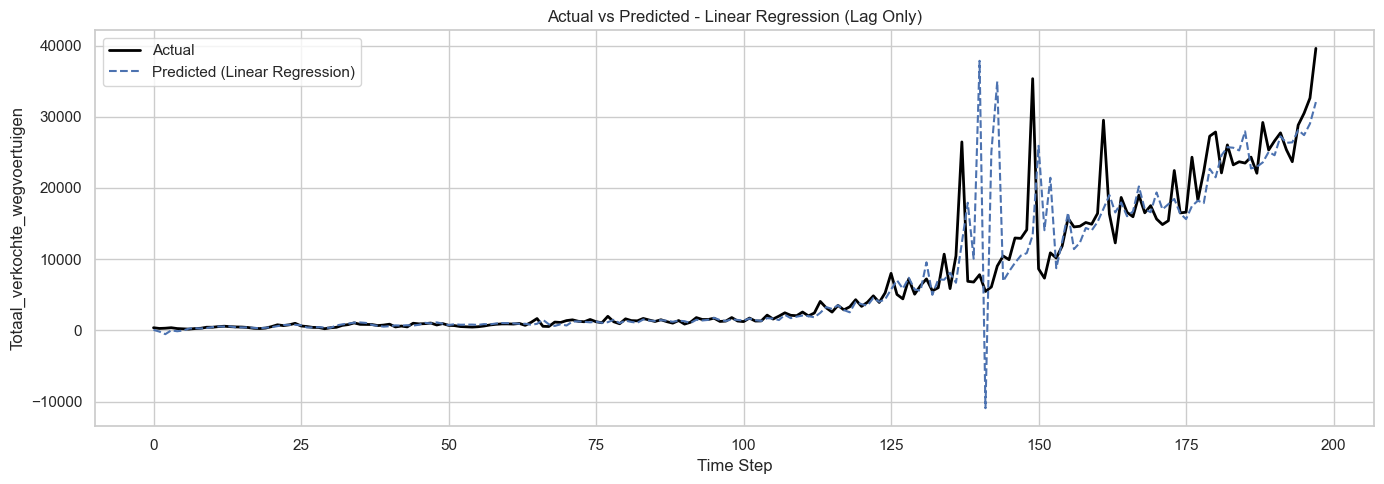

In [30]:
plt.figure(figsize=(14, 5))
plt.plot(actuals_lr, label='Actual', color='black', linewidth=2)
plt.plot(preds_lr, label='Predicted (Linear Regression)', color='C0', linestyle='--')
plt.title("Actual vs Predicted - Linear Regression (Lag Only)")
plt.xlabel("Time Step")
plt.ylabel("Totaal_verkochte_wegvoertuigen")
plt.legend()
plt.tight_layout()
plt.show()

In [31]:
# Only plot MAPE for the three models
axs.bar(x, mape_vals, width, color=['C0', 'C1', 'C2'])
axs.set_title('MAPE (%)')
axs.set_xticks(x)
axs.set_xticklabels(models_plot)
axs.set_ylabel('MAPE (%)')

plt.suptitle("Baseline (Lag Only) Model Performance")
plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

In [10]:
models = {
    'Linear Regression': lambda: LinearRegression(),
    'XGBoost': lambda: XGBRegressor(n_estimators=100, verbosity=0, random_state=42),
    'ElasticNet': lambda: ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000)
}

results = []

for fs_name, features in feature_sets.items():
    for model_name, model_fn in models.items():
        mae, rmse, r2, mape, _, _ = walk_forward_validation(df_lagged, features, target_col, model_fn)
        results.append({
            'Feature Set': fs_name,
            'Model': model_name,
            'MAE': mae,
            'RMSE': rmse,
            'R²': r2,
            'MAPE': mape
        })

results_df = pd.DataFrame(results)
results_df.sort_values(by="MAPE")


,Feature Set,Model,MAE,RMSE,R²,MAPE
4,Keywords + Lag,XGBoost,1376.315784,3142.850463,0.881099,22.427437
7,Bijtelling + Lag,XGBoost,1326.156482,2989.118933,0.892447,22.478938
1,(Lag Only),XGBoost,1325.425039,2987.822921,0.892540,22.509736
13,Fuel + Lag,XGBoost,1401.079481,3166.328763,0.879316,23.379260
10,Confidence + Lag,XGBoost,1429.729727,3000.572905,0.891621,23.948444
16,All Features,XGBoost,1729.011034,3646.791706,0.839912,26.459178
5,Keywords + Lag,ElasticNet,1777.372388,4381.202927,0.768941,28.046528
2,(Lag Only),ElasticNet,1767.172685,4558.065183,0.749909,28.353106
14,Fuel + Lag,ElasticNet,1766.841762,4557.898675,0.749928,28.557189
8,Bijtelling + Lag,ElasticNet,1775.204200,4564.499467,0.749203,29.373437


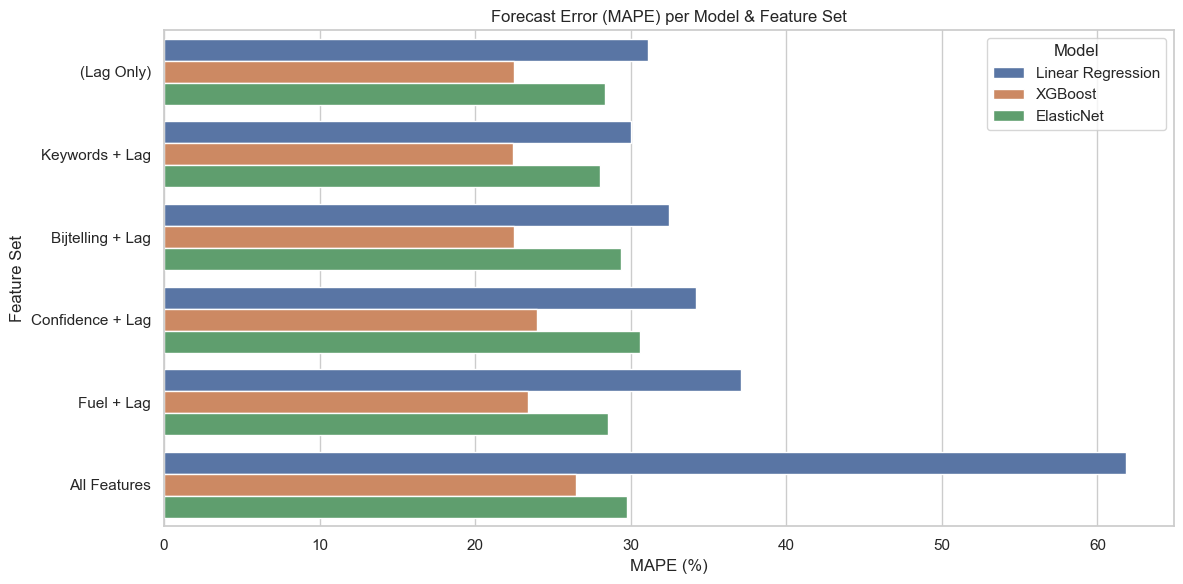

In [11]:
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(x="MAPE", y="Feature Set", hue="Model", data=results_df)
plt.title("Forecast Error (MAPE) per Model & Feature Set")
plt.xlabel("MAPE (%)")
plt.ylabel("Feature Set")
plt.legend(title="Model")
plt.tight_layout()
plt.show()
